In [1]:
import sys, os; sys.path.append(os.path.abspath("../")); 

from importlib import reload
import pandas as pd, numpy as np, torch
import _settings
import utils.utils as utils
import data.dataloader as dld; reload(dld)
import models.regmodel as regmodel; reload(regmodel)
import models.conformal as conformal; reload(conformal)
import demos.demo as demo; reload(demo)
import demos.regression as reg; reload(reg)
import demos.experiments as exp; reload(exp)
import data.preprocess_small_datasets as pmt; reload(pmt)
import utils.eval_utils as eval_utils; reload(eval_utils)
import matplotlib.pyplot as plt

#baselines
import models.baselines.MADSplit as MADSplit; reload(MADSplit)
import models.baselines.CQR as CQR; reload(CQR)

DATA_PATH = _settings.DATA_PATH
CACHE_PATH = os.path.join(_settings.WORKSPACE, 'Baselines')

cache_path = os.path.join(".", 'synthetic_results.pkl')

## 1. Data

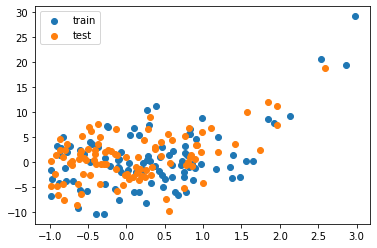

In [2]:
seed=0
ALPHA=0.1
dfs = {}

METHOD_NAME = "LVD"

datakwargs = {'dist': 'normal+', 'param': 1, 'sigma': 4}
train_obj = dld.DJKPSyntData(split=dld.TRAIN, seed=seed, n=100, **datakwargs)
val_obj = dld.DJKPSyntData(split=dld.VALID, seed=seed, n=100, **datakwargs)
test_obj = dld.DJKPSyntData(split=dld.TEST, seed=seed, n=100, **datakwargs)
plt.scatter(train_obj.x, train_obj.y, label='train')
plt.scatter(test_obj.x, test_obj.y, label='test')
plt.legend()

## 2. Plotting

If you could read the following, you don't need to run section 3

In [3]:
dfs = pd.read_pickle(cache_path) 

In [4]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() # Setting seabor
sns.set_style("whitegrid")

xlim = (-1, 3)
ylim = (-13, 23)


(0.0, 1.0, 0.0, 1.0)

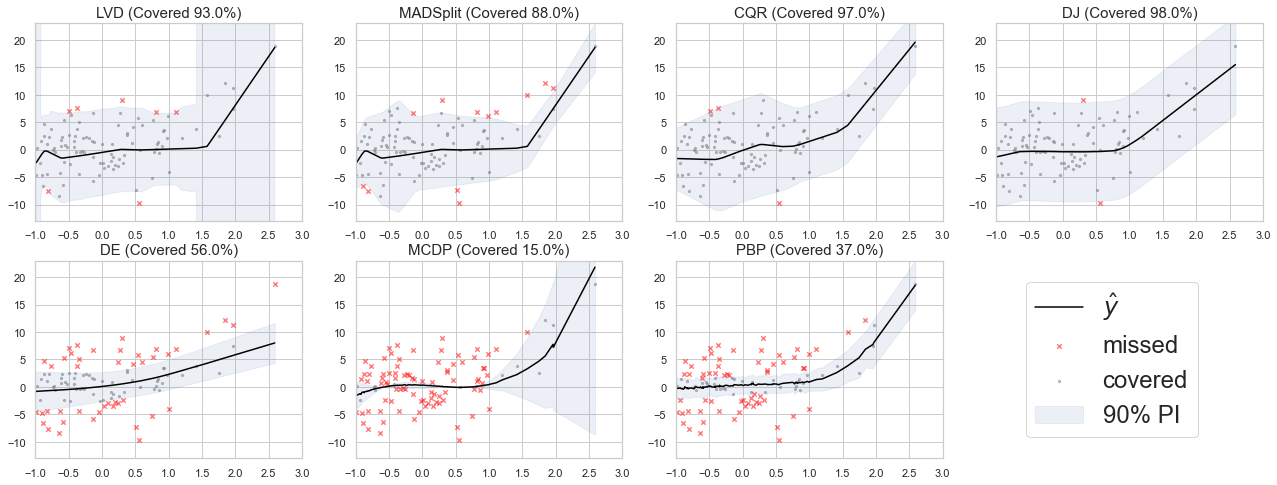

In [5]:
reload(eval_utils)
fig, axes = plt.subplots(2,4, figsize=(22, 8))
cell_text = []
ordered_methods = [METHOD_NAME, 'MADSplit', 'CQR',  'DJ', 'DE', 'MCDP', 'PBP']
for i, m in enumerate(ordered_methods):
    cplt = axes[i//4][i%4]
    
    df = dfs[m]
    cov_rate = (((df['y'] >= df['lo']) & (df['y'] <= df['hi']))).sum() / len(df) * 100
    eval_utils._plot_df_to_ax(cplt, df, 'x', fillinf=1000, smooth=False, s=20, show_cov=False, 
                              yhat_label='$\hat{y}$', PI_label='90% PI')
    cplt.set_title(f"{m} (Covered {cov_rate:.1f}%)", fontsize=15)
    cplt.set_ylim(*ylim)
    cplt.set_xlim(*xlim)
    
    cell_text.append([cov_rate])
    if i == len(ordered_methods) - 1:
        cplt.legend(loc='right', bbox_to_anchor=(1,0,1,1), fontsize=24)
    #ybar = df['y'].mean()
cplt = axes[1][3]
cplt.axis("off") 

#fig.savefig('./pics/Synthetic_Data_MainText.pdf', bbox_inches='tight', dpi=600)

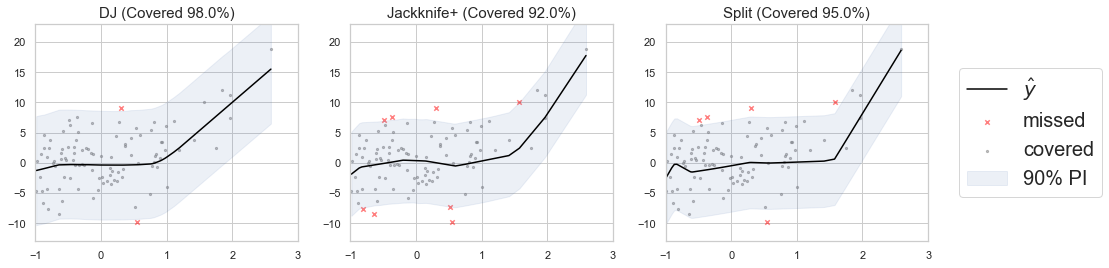

In [6]:
reload(eval_utils)
fig, axes = plt.subplots(1,3, figsize=(16, 4))
cell_text = []
ordered_methods = ['DJ', 'Jackknife+', 'Split']
for i, m in enumerate(ordered_methods):
    cplt = axes[i]
    
    df = dfs[m]
    cov_rate = (((df['y'] >= df['lo']) & (df['y'] <= df['hi']))).sum() / len(df) * 100
    eval_utils._plot_df_to_ax(cplt, df, 'x', fillinf=1000, smooth=False, s=20, show_cov=False,
                              yhat_label='$\hat{y}$', PI_label='90% PI')
    cplt.set_title(f"{m} (Covered {cov_rate:.1f}%)", fontsize=15)
    cplt.set_ylim(*ylim)
    cplt.set_xlim(*xlim)
    
    cell_text.append([cov_rate])
    if i == len(ordered_methods) - 1:
        lgd = cplt.legend(loc='right', bbox_to_anchor=(0.7,0,1,1), fontsize=20)

#fig.savefig('./pics/Synthetic_Data_AppendixDJ.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=600)

## 3. Training and Caching results


In [3]:
DNN_model, readout_layer = pmt.pretrain_general(np.expand_dims(train_obj.x,1), np.expand_dims(train_obj.y,1), seed=seed, 
                                                quiet=True, model_setting=0)
DNN_model_resid, readout_layer_resid = pmt.pretrain_general(np.expand_dims(train_obj.x,1), np.expand_dims(train_obj.y,1), seed=seed, 
                                                quiet=True, model_setting=0)

In [4]:
o = MADSplit.MADSplit(model_class=0)
o.fit(np.expand_dims(val_obj.x,1), val_obj.y, np.expand_dims(train_obj.x,1), train_obj.y, m=DNN_model, quiet=True)
dfs['MADSplit'] = conformal.PIConstructor.eval(np.expand_dims(test_obj.x,1), test_obj.y, o.PI, alpha=ALPHA, quiet=False)

eval_conformal: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 4167.09it/s]


In [5]:
reload(CQR)
o = CQR.CQR(model_class=0)
o.fit(np.expand_dims(val_obj.x,1), val_obj.y, np.expand_dims(train_obj.x,1), train_obj.y, quiet=True)
dfs['CQR'] = conformal.PIConstructor.eval(np.expand_dims(test_obj.x,1), test_obj.y, o.PI, alpha=ALPHA, quiet=False)

eval_conformal: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5000.36it/s]


## Method
#### Kernel Training

In [6]:
embed_train = DNN_model.embed(np.expand_dims(train_obj.x,1))
embed_val = DNN_model.embed(np.expand_dims(val_obj.x,1))
embed_test = DNN_model.embed(np.expand_dims(test_obj.x,1))

Setting seeds to 0


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:53<00:00,  9.36it/s]


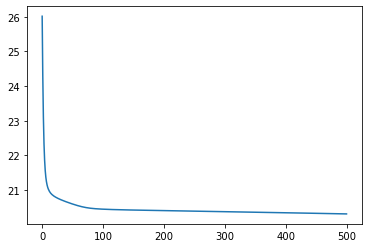

In [7]:
m = regmodel.KernelMLKR(d=10, seed=seed, n_iters=500, norm=True, lr=1e-3)
m.fit(embed_train, train_obj.y)
plt.plot(m._loss_hist)

#### Collect Residuals

In [8]:
oMethod = conformal.LocalConditional(K_obj=m)
oMethod.fit(embed_val, val_obj.y, m=readout_layer)

fit: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3936.02it/s]

MSE=19.156806452810542


In [9]:
res = oMethod.eval(embed_test, test_obj.y, oMethod.PI, alpha=ALPHA, quiet=False)
res['x'] = test_obj.x
dfs[METHOD_NAME] = res

eval_conformal: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1666.68it/s]


## Split

In [10]:
def dnn_m(x):
    x = torch.tensor(x, device=readout_layer.weight.device, dtype=torch.float)
    return float(readout_layer(x))
oSplit = conformal.VanillaSplit()
oSplit.fit(embed_val, val_obj.y, m=dnn_m)

test_X = np.expand_dims(test_obj.x,1)
Split_res = oSplit.eval(embed_test, test_obj.y, oSplit.PI, alpha=0.1, quiet=False)
Split_res['x'] = test_obj.x
dfs['Split'] = Split_res

eval_conformal: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3448.36it/s]


## Jackknife+

In [11]:
class DNN_(regmodel.BaseAlgo):
    def __init__(self):
        self.ALGO_NAME = "temp"
        super(DNN_, self).__init__()
    def fit(self,X,Y,seed=seed):
        self.m, self.r = pmt.pretrain_general(X, Y, seed=seed, quiet=True, model_setting=0)
    def predict(self,X):
        return self.m.predict(X)[0]
        
    
train_X = np.expand_dims(train_obj.x,1)
train_Y = np.expand_dims(train_obj.y,1)
val_X = np.expand_dims(val_obj.x,1)
val_Y = np.expand_dims(val_obj.y,1)


oJKP = conformal.JKPlus(DNN_)
oJKP.fit(np.concatenate([train_X, val_X],0), np.concatenate([train_Y, val_Y],0))

Fit JKP: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


In [12]:
test_X = np.expand_dims(test_obj.x,1)
JKP_res = oJKP.eval(test_X, test_obj.y, oJKP.PI, alpha=0.1, quiet=False)
JKP_res['x'] = test_obj.x
dfs['Jackknife+'] = JKP_res

eval_conformal: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.39it/s]


## Other baselines

In [13]:
reload(exp)
baselines = ["DJ", "DE", "MCDP", "PBP"]
dataset = 'DJKPSynthetic_normal+'
params = dict({"activation": 'ReLU', "num_hidden": 100, "num_layers": 1})
train_params = dict({"num_iter": 1000,  "learning_rate": 1e-3})
results = exp.run_experiments(baselines, [dataset], N_exp=1, damp=1e-2, 
                              mode='exact', #'exact'
                              coverage=.9, 
                              params=params, train_params=train_params,
                              data_path=DATA_PATH, cache_path = CACHE_PATH)

for m in results.keys():
    dfs[m] = results[m][dataset][0]

Running experiments on dataset:  DJKPSynthetic_normal+
Exp: 0


exact_hessian: 100%|██████████████████████████████| 1/1 [00:00<00:00, 83.33it/s]


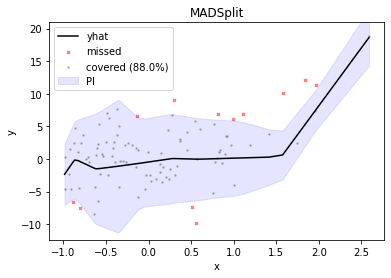

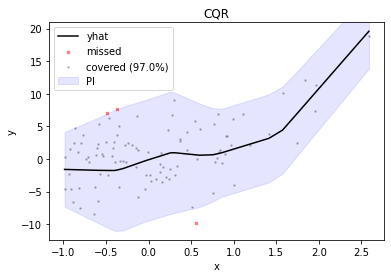

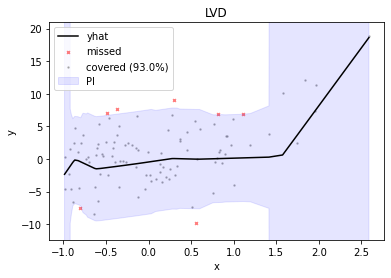

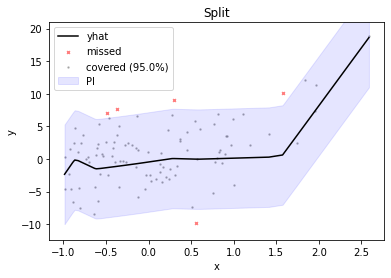

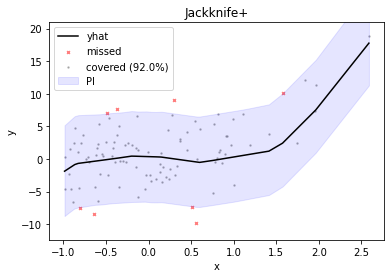

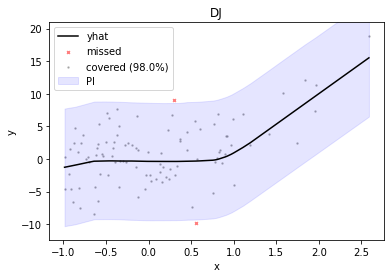

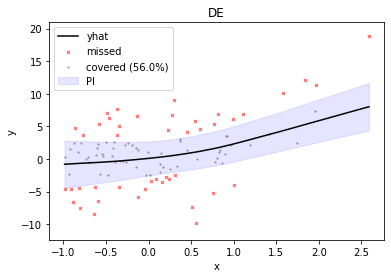

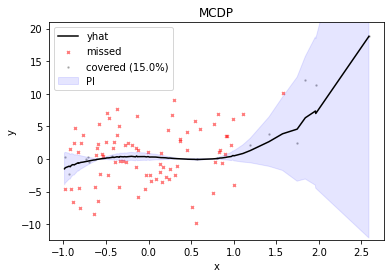

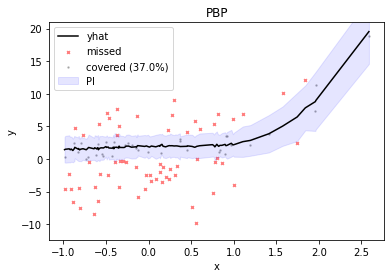

In [14]:
for m,df in dfs.items():
    _ = eval_utils.plot_df(df, 'x', fillinf=1000, smooth=False, title=m)

### Uncomment the following to overwrite the results

In [15]:
#pd.to_pickle(dfs, cache_path)